# Self-Driving Car Engineer Nanodegree


## Project #1: **Finding Lane Lines on the Road** 

***

David Cato - June 2017
<br>Submission #1

**The goals of this project are to:**
* Make a pipeline that finds lane lines on the road (this file)
* Reflect on the project (writeup.md)

**At a high level, this first goal (create a lane line pipeline) was accomplished by:**

1) Detecting the line segments in an image  
2) Averaging/extrapolating the line segments and drawing them onto the image for display  
3) Testing the lane line annotation pipeline by running it over video streams  

## Import Packages

In [1]:
#importing some useful packages
import cv2
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

# packages needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, clips_array
from IPython.display import HTML

%matplotlib inline

## Define Image Pipeline Helper Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices=None, scale_height=2, width_offset_px=10):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    if vertices is None:
        vertices = lane_region_vertices(img.shape, scale_height, width_offset_px)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness` onto `img`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def weighted_hough_lane_lines(img, rho, theta, threshold, min_line_len, max_line_gap, min_segment_slope=0.5, weight=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # process_lane_lines returns one average left line and one average right line
    processed_lines = process_lane_lines(lines, img.shape, min_segment_slope, weight=weight)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, processed_lines, thickness=4)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as: initial_img * α + img * β + λ
    
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

###########################
# Custom helper functions #
###########################
def figure_plot(imgs, plots_per_row=1, figsize=(40, 20), is_gray=False):
    """
    `imgs` is a list of images to plot in a figure.
    
    `plots_per_row` specifies the number of plots per row in the figure
    
    Displays a figure containing plots of all images in `imgs`
    """
    plots_per_column = math.ceil(1. * len(imgs) / plots_per_row )
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(imgs, 1):
        fig.add_subplot(plots_per_column, plots_per_row, i)
        if is_gray:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()
    return

def import_image_files(directory, suffix='.jpg'):
    """Returns a list of images from the specified directory"""
    images = []
    for file in os.listdir(directory):
        if not file.endswith(suffix):
            continue
        filepath = os.path.join(directory, file)
        image = mpimg.imread(filepath)
        images.append(image)
    return images

def lane_region_vertices(img_shape, scale_height=2, width_offset_px=10):
    """
    Returns vertices of a quadrilateral in the general area you expect to find lane lines.
    E.g. --------------
         |            |
         |            |
         |    ----    | <-- here, width_offset_px=2 (where 1 dash = 1 pixel)
         |  /      \  |
         |/          \|
         --------------
    
    Reduce `scale_height` to make the quadrilateral shorter.
    
    Increase or reduce `width_offset_px` to widen or shrink the shorter top of the quadrilateral.
    """
    height, width = img_shape[0], img_shape[1]
    return np.array([[(0, height),
                      (width/2-width_offset_px, height/scale_height), 
                      (width/2+width_offset_px, height/scale_height), 
                      (width, height)]], dtype=np.int32)

def process_lane_lines(line_segments, img_shape, min_segment_slope, weight=False):
    """
    Filters out line segments with a slope less than `min_segment_slope`.
    
    Optionally, set `weight` to True to average and extrapolate the left and right 
    line segments to return one left and one right lane lines.
    
    Otherwise, return the filtered list of line segments.
    """
    # format input to remove extra list
    segments = []
    for segment in line_segments:
        segments.append(segment[0])
    
    # convert to numpy array
    segments = np.array(segments)
    
    img_y, img_x = img_shape[0], img_shape[1]
    
    # split left and right lines by slope
    # also filter out lines with too-horizontal slopes
    x1, y1, x2, y2 = segments[:,0], segments[:,1], segments[:,2], segments[:,3]
    dx, dy = x2 - x1, y2 - y1
    slope_filter = abs(dy / dx) > min_segment_slope
    is_left = np.logical_and(np.logical_and(dx * dy < 0, # y axis is down so left segments have negative slope
                                            np.maximum(x1, x2) < img_x/2+10), 
                             slope_filter)
    is_right = np.logical_and(np.logical_and(dx * dy > 0, # and right segments have positive slope
                                             np.minimum(x1, x2) > img_x/2-10), 
                              slope_filter)
    
    # Whether to average and extrapolate the valid segments into the final 2 lane lines
    if weight:
        # find weighted average slopes
        left_dx, left_dy = np.sum(dx[is_left]), np.sum(dy[is_left])
        left_slope = left_dy / left_dx
        right_dx, right_dy = np.sum(dx[is_right]), np.sum(dy[is_right])
        right_slope = right_dy / right_dx

        # find min/max y and calculate intercepts
        min_y, max_y = np.min([y1, y2]), np.max([y1, y2])
        left_intercepts = y1[is_left] - left_slope * x1[is_left]
        left_weights = np.sqrt(np.square(dx[is_left]) + np.square(dy[is_left]))
        avg_left_intercept = np.sum(left_intercepts * left_weights) / np.sum(left_weights)
        right_intercepts = y1[is_right] - right_slope * x1[is_right]
        right_weights = np.sqrt(np.square(dx[is_right]) + np.square(dy[is_right]))
        avg_right_intercept = np.sum(right_intercepts * right_weights) / np.sum(right_weights)

        # calculate left and right x endpoints from min/max y's
        min_avg_x_left = (min_y - avg_left_intercept) / left_slope
        max_avg_x_left = (max_y - avg_left_intercept) / left_slope
        min_avg_x_right = (min_y - avg_right_intercept) / right_slope
        max_avg_x_right = (max_y - avg_right_intercept) / right_slope
        
        # put together average line segments, round to nearest int, and cast to int
        avg_left_segment = np.rint([min_avg_x_left, min_y, max_avg_x_left, max_y]).astype(int)
        avg_right_segment = np.rint([min_avg_x_right, min_y, max_avg_x_right, max_y]).astype(int)
        avg_line_segments = np.array([[avg_left_segment.tolist()], [avg_right_segment.tolist()]])
        
        return avg_line_segments
    # Don't average the lines
    else:
        filtered_line_segments = []
        
        for row_ix, row in enumerate(segments):
            if is_left[row_ix] or is_right[row_ix]:
                filtered_line_segments.append([segments[row_ix,:].tolist()])
                
        filtered_line_segments = np.array(filtered_line_segments)
        return filtered_line_segments

## Test Images

Make sure the pipeline works well on the images in the directory "test_images" before you trying the videos.

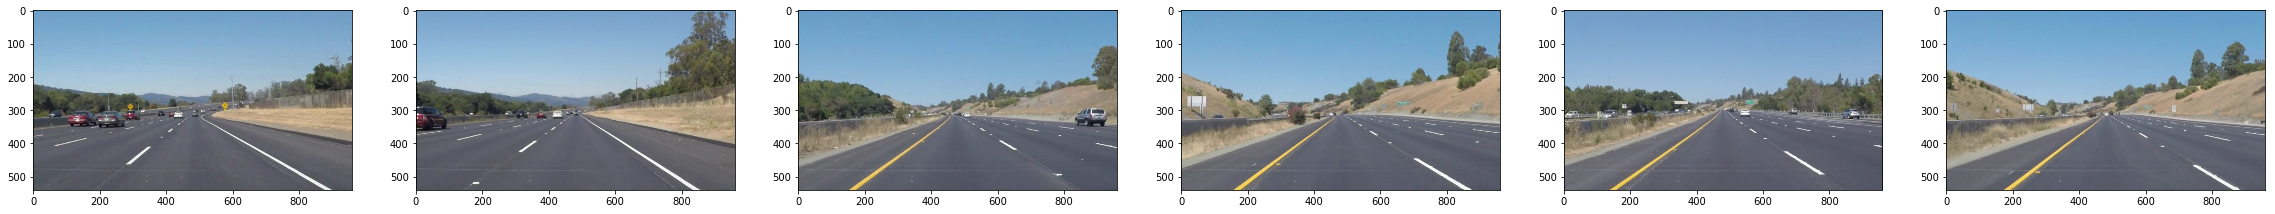

In [3]:
dir = "test_images/"
images = import_image_files(dir)
figure_plot(images, 6)

## Build a Lane Finding Pipeline

In [4]:
# Accumulate images to plot in a new list
imgs_to_save = [[images[i], 'test_img{0}-0_original.jpg'.format(i+1)] for i in range(len(images))]

# 1) Convert image to grayscale
grays = [grayscale(image) for image in images]
imgs_to_save.extend([[grays[i], 'test_img{0}-1_gray.jpg'.format(i+1)] for i in range(len(grays))])

# 2) Apply a gaussian blur
blur_grays = [gaussian_blur(gray, kernel_size = 5) for gray in grays]
imgs_to_save.extend([[blur_grays[i], 'test_img{0}-2_blur_gray.jpg'.format(i+1)] for i in range(len(blur_grays))])

# 3) Identify edges using Canny edge detection function
low_threshold = 50
high_threshold = 3*low_threshold
edges = [canny(blur_gray, low_threshold, high_threshold) for blur_gray in blur_grays]
imgs_to_save.extend([[edges[i], 'test_img{0}-3_edges.jpg'.format(i+1)] for i in range(len(edges))])

# 4) Mask the image to remove noise from edges detected where lanes aren't expected
masked_edges = [region_of_interest(edges_img, scale_height=1.7, width_offset_px=10) for edges_img in edges]
imgs_to_save.extend([[masked_edges[i], 'test_img{0}-4_masked_edges.jpg'.format(i+1)] for i in range(len(masked_edges))])

# 5) Identify lines using a Hough transform
rho = 1 # distance resolution in pixels of the Hough grid
theta = .1*np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 # minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

lines = [weighted_hough_lane_lines(masked_edges_img, rho, theta, 
                                   threshold, min_line_length, 
                                   max_line_gap, weight=True) for masked_edges_img in masked_edges]
imgs_to_save.extend([[lines[i], 'test_img{0}-5_lines.jpg'.format(i+1)] for i in range(len(lines))])

images_with_lines = [weighted_img(lines[i], images[i]) for i in range(len(lines))]
imgs_to_save.extend([[images_with_lines[i], 'test_img{0}-6_images-with-lines.jpg'.format(i+1)] for i in range(len(images_with_lines))])

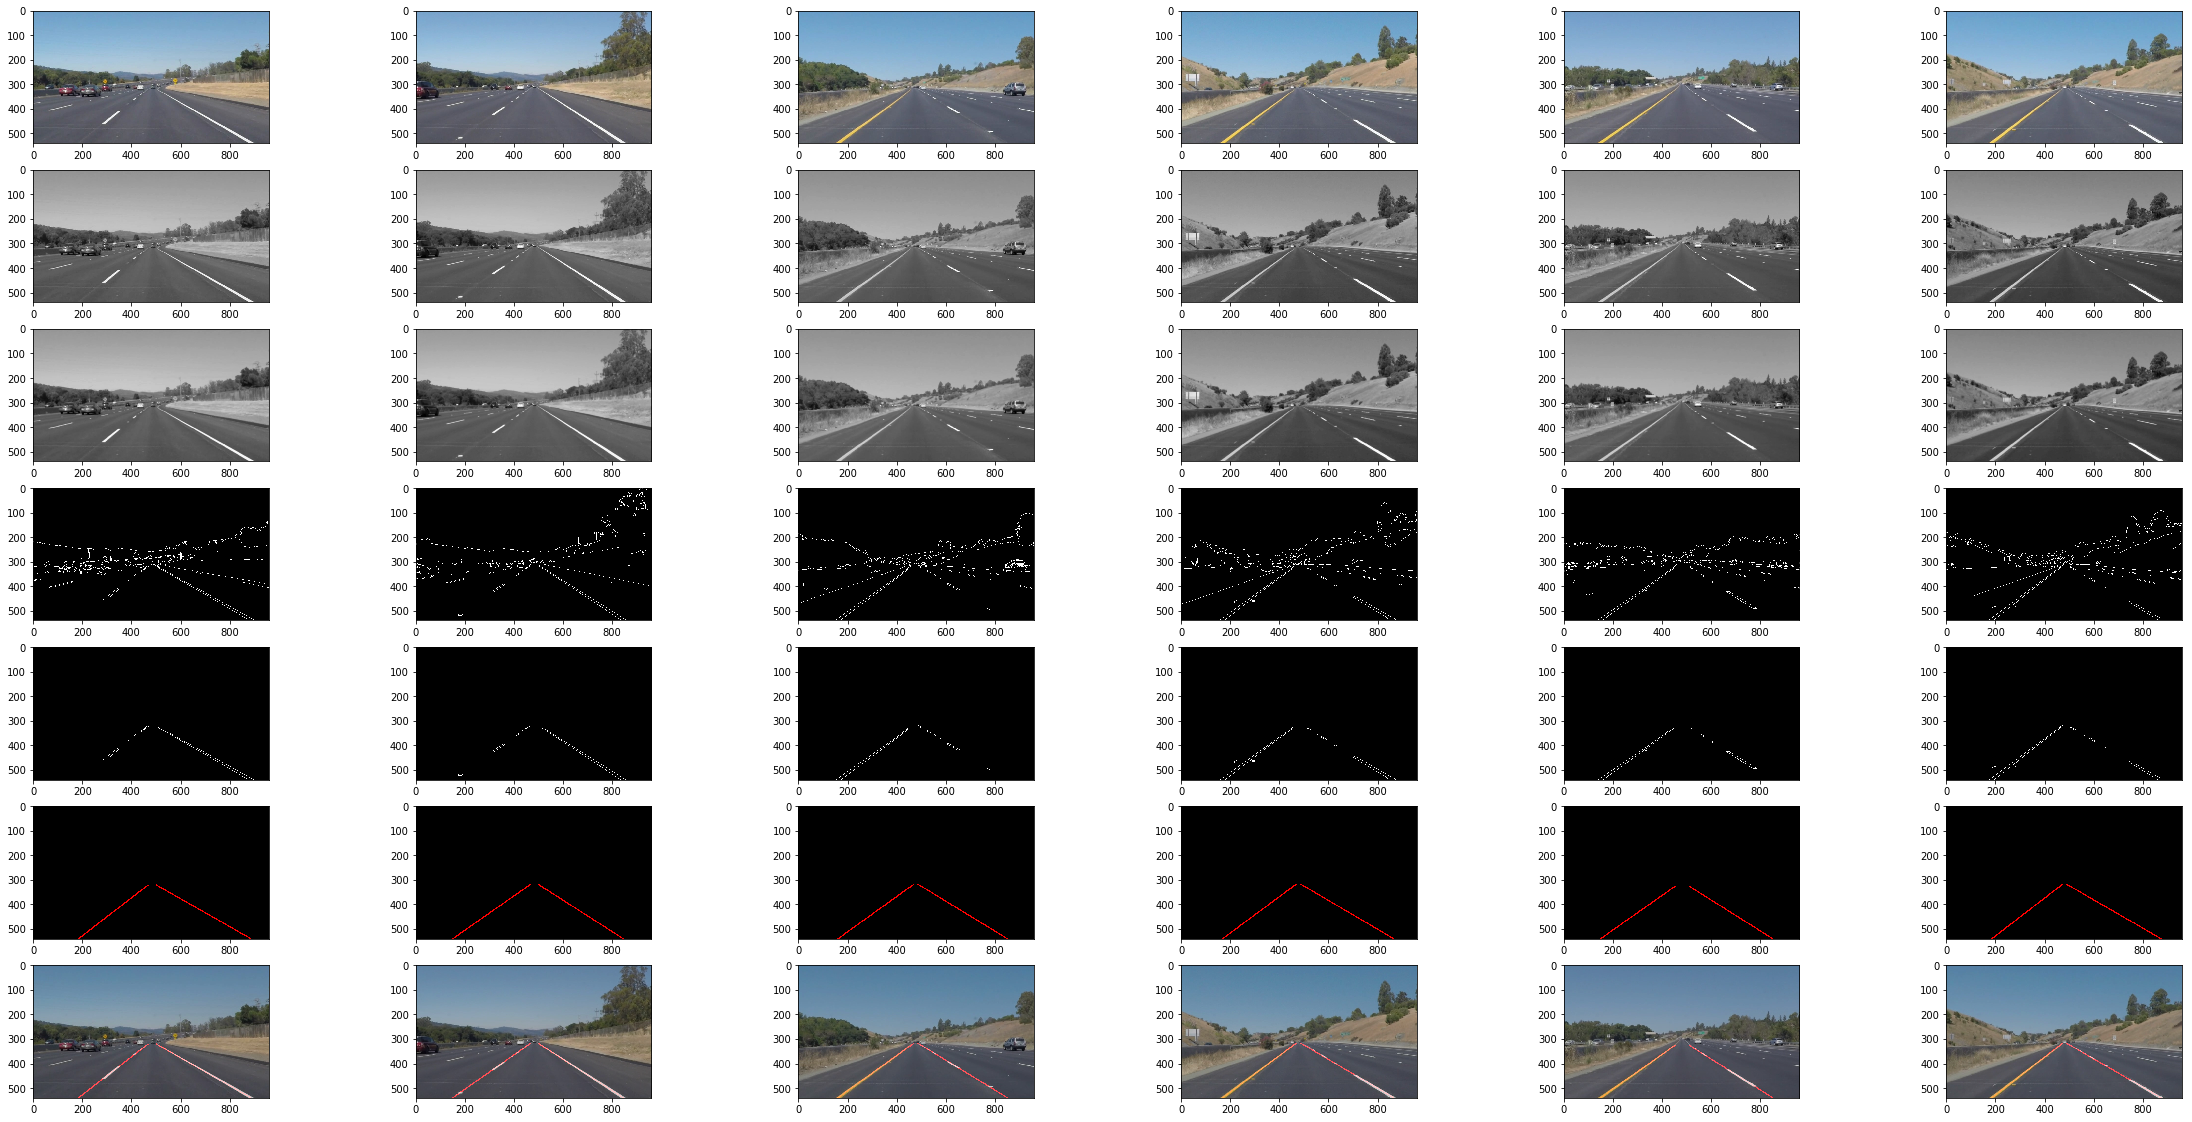

In [5]:
# Plot test images along every step of the pipeline to ensure it looks good before moving to video.
imgs_to_plot = [img for img, filename in imgs_to_save]
figure_plot(imgs_to_plot, 6, is_gray=True) # setting `is_gray` makes grayscale look right and weirdly still works for color images, so just going with it for now

**Great! Now that the pipeline is working for our test images, let's save our images for later and put this all together into a single function which we'll end up passing to moviepy for processing whole videos.**

In [6]:
# Save images
save_dir = "test_images_output/"
for img, filename in imgs_to_save:
    if len(img.shape) == 3:
        # note cv2 expects images in BGR format
        cv2.imwrite(os.path.join(save_dir, filename), img[:,:,[2,1,0]], [cv2.IMWRITE_JPEG_QUALITY, 90])
    else:
        cv2.imwrite(os.path.join(save_dir, filename), img, [cv2.IMWRITE_JPEG_QUALITY, 90])

## Define the Lane Finding Pipeline

In [7]:
def lane_line_pipeline(img, debug=''):
    """
    Detects lane lines in `img` and returns an annotated
    image containing the detected lane lines.
    
    Set the `debug` parameter to 'canny', 'mask', or 'hough'
    to see how well these steps are performing.
    """
    # Canny edge detection parameters
    low_threshold = 50
    high_threshold = 3*low_threshold
    
    # Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = .1*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 # minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    
    ## Pipeline ##
    
    # convert to grayscale
    gray = grayscale(img)
    
    # Gaussian blur
    blur_gray = gaussian_blur(gray, kernel_size = 5)
    
    # Canny edge detection
    edges = canny(blur_gray, low_threshold, high_threshold)
    if debug == 'canny':
        return cv2.cvtColor(edges,cv2.cv.CV_GRAY2RGB)
    
    # region mask
    masked_edges = region_of_interest(edges, scale_height=1.7, width_offset_px=10)
    if debug == 'mask':
        return cv2.cvtColor(masked_edges,cv2.cv.CV_GRAY2RGB)
    
    # Hough transform
    if debug == 'hough':
        lines = weighted_hough_lane_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, weight=False)
        return cv2.cvtColor(lines,cv2.cv.CV_GRAY2RGB)
    weighted_lines = weighted_hough_lane_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, weight=True)
    
    # Superimpose lane lines over original image
    img_with_lines = weighted_img(weighted_lines, img)
    
    return(img_with_lines)

# moviepy requires a function with only one parameter `image`
#  so define primary pipeline function as well as 3 debug functions
def process_image(image):
    return lane_line_pipeline(image)

def process_image_canny(image):
    return lane_line_pipeline(image, debug='canny')

def process_image_mask(image):
    return lane_line_pipeline(image, debug='mask')

def process_image_hough(image):
    return lane_line_pipeline(image, debug='hough')

**Video #1 with a solid white lane on the right first ...**

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:16<00:00, 13.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 16.9 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**Video #2, with a solid yellow lane on the left.**

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:43<00:00, 15.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 44.3 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video #3

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:34<00:00,  7.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 35.9 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))